In [1]:
import numpy as np
import itertools
from matplotlib import pyplot as plt

# Contrast Transfer Function

*Reference: https://en.wikipedia.org/wiki/Contrast_transfer_function*


$$
\begin{aligned}
H_{CTF}(f, t) & =(1-\alpha) \sin (D(f, t)) - \alpha \cos (D(f,t)) \\
D(f,t) & = 2 \pi \lambda f^2 (- \frac{\Delta d(t)}{2} + \frac{\lambda^2 f^2 C_s}{4})
\end{aligned}
$$

该公式参考 *TR-2008011: Contrast Transfer Function Correction in Electron Microscopy, p.g. 7*

注意：其实只有频率 $f$ 是变量，其他都是通过各种办法得到的、固定的值，所以 CTF 是一个长得像三角函数的东西。

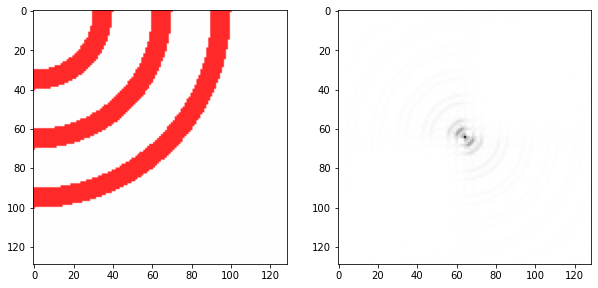

In [115]:
plt.figure(figsize=(10, 8))
D = 128 + 1
O = D // 2
x = np.zeros([D, D])
for i, j in itertools.product(range(D), range(D)):
    for radii in [30, 60, 90]:
        if radii ** 2 <= i ** 2 + j ** 2 <= (radii + 10) ** 2:
            x[i][j] = 1
plt.subplot(1, 2, 1)
plt.imshow(x, 'bwr', vmin=-1.2, vmax=1.2)

fx = np.fft.fftshift(np.fft.fft2(x))
plt.subplot(1, 2, 2)
plt.imshow(np.abs(fx), 'binary')

## CTF

- 关于 CTF 本身：CTF 函数只与频率有关。
- CTF 在高频区域变化很剧烈，但是大部分聚焦在 -1 和 1，估计这个是 phase flipping 的动机。
- 由于频率过高，plot 出来的 CTF 形状受到采点数量的影响，采点过少时，CTF 的形状会很诡异，可以尝试 $\mathrm{nx}=128$

(array([108.,  44.,  45.,  38.,  38.,  34.,  30.,  38.,  41.,  96.]),
 array([-9.99998769e-01, -7.99998902e-01, -5.99999036e-01, -3.99999169e-01,
        -1.99999302e-01,  5.65460211e-07,  2.00000432e-01,  4.00000299e-01,
         6.00000166e-01,  8.00000033e-01,  9.99999900e-01]),
 <BarContainer object of 10 artists>)

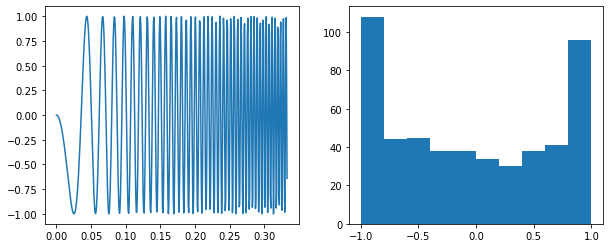

In [226]:
# Code adapted from https://github.com/geoffwoollard/learn_cryoem_math/blob/master/nb/ctf_aliasing.ipynb
defocus = 4
nx = 1024

def ctf_1d(defocus, nx, pix=1.5):
    voltage = 300  # in kev
    lam = 12.398 / np.sqrt(voltage * (1022.0 + voltage))  #  All units in A
    Cs = 2

    freq = np.arange(start=0, stop=1 / (2 * pix), step=1 / (nx * pix))
    cis = Cs * 1.e7  # mm
    A = 0.5 * defocus * 10000.0 * lam  # defocus in um
    B = 0.25 * cis * lam * lam * lam
    f2 = freq * freq
    gamma = 2 * np.pi * (-A * f2 + B * f2 * f2)
    return (np.sin(gamma), freq)


ctf, freq = ctf_1d(defocus, nx)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# plt.scatter(freq, ctf, marker='+', color='g')
plt.plot(freq, ctf)
plt.subplot(1, 2, 2)
plt.hist(ctf)

## 尝试不同的 Filter 对结果的影响

这里使用 `fast_sine_filter` 或者 `period_negation_filter` 模拟 CTF。

显然，频率空间中的 negation 直接导致实空间的 negation：
$$
f(x) = \frac{1}{2\pi} \int_\mathbb{R}  \hat{f}(\xi) e^{iwx} dw \\
- f(x) = \frac{1}{2\pi} \int_\mathbb{R}  -\hat{f}(\xi) e^{iwx} dw
$$

CTF 的（主要）作用类似于快速进行符号翻转（我猜测）：
$$
f(x) = \frac{1}{2\pi} \int_\mathbb{R}  \left[ \hat{f}(\xi)  \sin (20 \xi) \right] e^{iwx} dw
$$

In [263]:
def get_freq(i, j):
    return np.sqrt((i - O) ** 2 + (j - O) ** 2)

def low_pass_filter(f):
    return np.exp(-f ** 2 / O ** 2 * 5)

def high_pass_filter(f):
    return 1 - low_pass_filter(f)

def slow_sine_filter(f):
    return np.sin(f * 0.2)

def fast_sine_filter(f):
    return np.sin(f * 20)

def negation_filter(f):
    return -1

def high_negation_filter(f):
    if low_pass_filter(f) > 0.5:
        return 1
    else:
        return -1

def low_negation_filter(f):
    if low_pass_filter(f) < 0.5:
        return 1
    else:
        return -1

def period_negation_filter(f):
    if f % 2 == 1:
        return 1
    else:
        return -1

def generate_filter(filter_fn):
    c = np.zeros([D, D])
    for i, j in itertools.product(range(D), range(D)):
        c[i][j] = filter_fn(get_freq(i, j))
    return c


Text(0.5, 1.0, 'denoise(noise(x))')

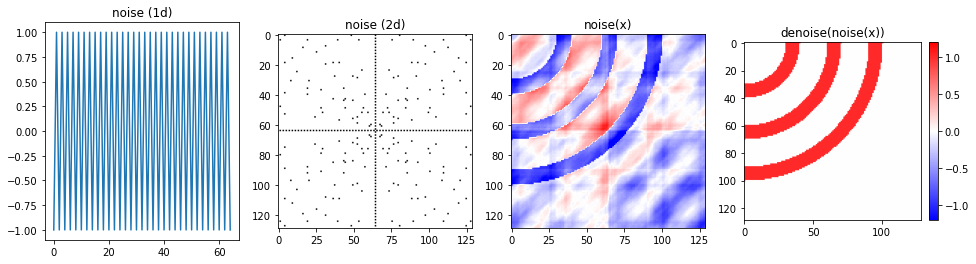

In [264]:
# Generate noise
plt.figure(figsize=(16, 4))
# c = generate_filter(negation_filter)
# c = generate_filter(low_negation_filter)
# c = generate_filter(high_negation_filter)
c = generate_filter(period_negation_filter)
# c = generate_filter(slow_sine_filter)
# c = generate_filter(fast_sine_filter)

plt.subplot(1, 4, 1)
plt.plot(c[O][O:])
plt.title("noise (1d)")

plt.subplot(1, 4, 2)
plt.imshow(c, 'binary')
plt.title("noise (2d)")

# Add noise
noise_x = fx * c
x2 = np.fft.ifft2(np.fft.ifftshift(fx * c))
assert x2.imag.sum() < 1e-3
plt.subplot(1, 4, 3)
plt.imshow(x2.real, 'bwr', vmin=-1.2, vmax=1.2)
# plt.colorbar(fraction=0.046, pad=0.04)
plt.title("noise(x)")

# Denoise
denoise_noise_x = noise_x * np.sign(c)
x3 = np.fft.ifft2(np.fft.ifftshift(denoise_noise_x))
plt.subplot(1, 4, 4)
plt.imshow(x3.real, 'bwr', vmin=-1.2, vmax=1.2)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("denoise(noise(x))")